# Article Similarity Project

In this project, we are interested in understanding the current conceptions of equity that emerge from a review of the literature. In order to understand this systematically, we aim to use topic modeling to discover the latent “topics” that occur in a collection of equity-oriented mathematics education journal articles.

I drew inspiration/implementation ideas from a number of resources:
1. Susan Li's blogpost: [Topic Modelling in Python with NLTK and Gensim](https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21)
2. Selva Prabhakaran's blogpost: [Topic Modeling with Gensim (Python)](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/)
3. Félix Revert's post: [An Overview of Topics Extraction in Python with Latent Dirichlet Allocation](https://www.kdnuggets.com/2019/09/overview-topics-extraction-python-latent-dirichlet-allocation.html)
4. Shashank Kapadia's post: [Topic Modeling in Python: Latent Dirichlet Allocation (LDA)](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0)
5. Julia Silge and David Robinson's chapter on Topic Modeling in [Text Mining with R](https://www.tidytextmining.com/topicmodeling.html)

## Step 1. Load libraries

In [157]:
%matplotlib inline  

#Visuals
import pyLDAvis
import pyLDAvis.gensim 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

#Tools
import csv
import glob
import os
import sys
import pandas as pd 
#import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
from nltk import FreqDist
from scipy.stats import entropy
import xmltodict
import warnings

## Step 2. Reading and Cleaning Data

In [158]:
#Here, we set up the directory of the xml file we downloaded from the database
xml_file = "data/equity2.xml"

# Open up the xml file, and convert to a dictionary
with open(xml_file, encoding="utf8") as fd:
    doc = xmltodict.parse(fd.read())

"""The xml file has many, many subtags. This helps flatten so we can get the more relevant information.
Used dividebyzero's implentation from Stackoverflow:
https://stackoverflow.com/questions/6027558/flatten-nested-dictionaries-compressing-keys"""
    
def flatten_dict(dd, separator='_', prefix=''):
    return { prefix + separator + k if prefix else k : v
             for kk, vv in dd.items()
             for k, v in flatten_dict(vv, separator, kk).items()
             } if isinstance(dd, dict) else { prefix : dd }

#Apply the flatten function to the dictionary created above.
flattened_doc = [flatten_dict(x) for x in doc['records']['rec']]

#Put all of this information into a dataframe.
data1 = pd.DataFrame(flattened_doc)

In [159]:
data1.columns

Index(['@resultID', 'header_@shortDbName', 'header_@longDbName',
       'header_@uiTerm', 'header_controlInfo_bkinfo',
       'header_controlInfo_jinfo_jtl', 'header_controlInfo_jinfo_issn',
       'header_controlInfo_pubinfo_dt_@year',
       'header_controlInfo_pubinfo_dt_@month',
       'header_controlInfo_pubinfo_dt_@day',
       'header_controlInfo_pubinfo_dt_#text', 'header_controlInfo_pubinfo_vid',
       'header_controlInfo_pubinfo_iid', 'header_controlInfo_artinfo_ppf',
       'header_controlInfo_artinfo_ppct', 'header_controlInfo_artinfo_formats',
       'header_controlInfo_artinfo_tig_atl',
       'header_controlInfo_artinfo_aug_au',
       'header_controlInfo_artinfo_aug_affil',
       'header_controlInfo_artinfo_sug_subj', 'header_controlInfo_artinfo_ab',
       'header_controlInfo_artinfo_pubtype',
       'header_controlInfo_artinfo_doctype',
       'header_controlInfo_language_@code',
       'header_controlInfo_language_#text', 'header_displayInfo_pLink_url',
       'hea

In [160]:
pd.set_option('display.max_columns', None)

In [161]:
data1.head()

,@resultID,header_@shortDbName,header_@longDbName,header_@uiTerm,header_controlInfo_bkinfo,header_controlInfo_jinfo_jtl,header_controlInfo_jinfo_issn,header_controlInfo_pubinfo_dt_@year,header_controlInfo_pubinfo_dt_@month,header_controlInfo_pubinfo_dt_@day,header_controlInfo_pubinfo_dt_#text,header_controlInfo_pubinfo_vid,header_controlInfo_pubinfo_iid,header_controlInfo_artinfo_ppf,header_controlInfo_artinfo_ppct,header_controlInfo_artinfo_formats,header_controlInfo_artinfo_tig_atl,header_controlInfo_artinfo_aug_au,header_controlInfo_artinfo_aug_affil,header_controlInfo_artinfo_sug_subj,header_controlInfo_artinfo_ab,header_controlInfo_artinfo_pubtype,header_controlInfo_artinfo_doctype,header_controlInfo_language_@code,header_controlInfo_language_#text,header_displayInfo_pLink_url,header_controlInfo_artinfo_aug,header_controlInfo_artinfo_sug_subj_@type,header_controlInfo_artinfo_sug_subj_#text
0,1,eax,Education Abstracts (H.W. Wilson),135309477,None,Journal of Teacher Education,00224871,2019,03,01,Mar/Apr2019,70,2,139,16,None,Measuring Teaching Quality of Secondary Mathem...,"[Nava, Imelda, Park, Jaime, Dockterman, Danny,...","University of California, Los Angeles, USA","[{'@type': 'thes', '#text': 'Mathematics educa...",This study assesses the reliability of two obs...,Academic Journal,Article,eng,English,http://proxy.lib.umich.edu/login?url=http://se...,NaN,NaN,NaN
1,2,eax,Education Abstracts (H.W. Wilson),137159246,None,Journal for Research in Mathematics Education,00218251,2019,07,01,Jul2019,50,4,349,13,None,Unpacking the Links Between Equitable Teaching...,"[Barajas-López, Filiberto, Larnell, Gregory V.]","[University of Washington, University of Illin...",NaN,"In their commentary, ""Toward a Framework for R...",Academic Journal,Article,eng,English,http://proxy.lib.umich.edu/login?url=http://se...,NaN,NaN,NaN
2,3,eax,Education Abstracts (H.W. Wilson),136109754,None,Journal for Research in Mathematics Education,00218251,2019,05,01,May2019,50,3,268,43,None,A Qualitative Metasynthesis of Teaching Mathem...,"Harper, Frances K.","University of Tennessee, Knoxville",NaN,Mathematics classrooms are increasingly becomi...,Academic Journal,Article,eng,English,http://proxy.lib.umich.edu/login?url=http://se...,NaN,NaN,NaN
3,4,eax,Education Abstracts (H.W. Wilson),112740992,None,Teacher Education Quarterly,07375328,2015,10,01,Fall2015,42,4,83,18,None,Mathematics Teacher Educators Focusing on Equi...,"[Vomvoridi-Ivanovic, Eugenia, McLeman, Laura]","[Assistant professor of mathematics, Teaching ...","[{'@type': 'thes', '#text': 'Qualitative resea...",The article presents the result of the qualita...,Academic Journal,Article,eng,English,http://proxy.lib.umich.edu/login?url=http://se...,NaN,NaN,NaN
4,5,eax,Education Abstracts (H.W. Wilson),84964058,None,Journal for Research in Mathematics Education,00218251,2013,01,01,Jan2013,44,1,164,35,None,Negotiating Social Justice Teaching: One Full-...,"Gregson, Susan A.",University of Cincinnati,"[{'@type': 'thes', '#text': 'Mathematics educa...",This case study examines the practice of a ful...,Academic Journal,Article,eng,English,http://proxy.lib.umich.edu/login?url=http://se...,NaN,NaN,NaN


In [162]:
df = data1[['@resultID', 'header_controlInfo_jinfo_jtl', 'header_controlInfo_artinfo_tig_atl','header_controlInfo_artinfo_ab', 
            'header_controlInfo_artinfo_aug_au', 'header_controlInfo_pubinfo_dt_#text']]

In [163]:
df.columns = ['article_ID','Journal_Title', 'Article_Title', 'Article_Abstract',
                     'Authors','Year_of_Publication']

In [164]:
# According to the Pandas documentation, I believe I'm getting a false-positive warning here,
# I want to write on original dataframe.

# I used the pandas documentation here: 
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.replace.html

pd.options.mode.chained_assignment = None

df['Year_of_Publication'].replace(regex=True,inplace=True,to_replace=r'\D',value=r'')

In [165]:
df = df.astype({"Authors": str,"Article_Abstract": str, "Article_Title": str})

In [166]:
df.dropna()

,article_ID,Journal_Title,Article_Title,Article_Abstract,Authors,Year_of_Publication
0,1,Journal of Teacher Education,Measuring Teaching Quality of Secondary Mathem...,This study assesses the reliability of two obs...,"['Nava, Imelda', 'Park, Jaime', 'Dockterman, D...",2019
1,2,Journal for Research in Mathematics Education,Unpacking the Links Between Equitable Teaching...,"In their commentary, ""Toward a Framework for R...","['Barajas-López, Filiberto', 'Larnell, Gregory...",2019
2,3,Journal for Research in Mathematics Education,A Qualitative Metasynthesis of Teaching Mathem...,Mathematics classrooms are increasingly becomi...,"Harper, Frances K.",2019
3,4,Teacher Education Quarterly,Mathematics Teacher Educators Focusing on Equi...,The article presents the result of the qualita...,"['Vomvoridi-Ivanovic, Eugenia', 'McLeman, Laura']",2015
4,5,Journal for Research in Mathematics Education,Negotiating Social Justice Teaching: One Full-...,This case study examines the practice of a ful...,"Gregson, Susan A.",2013
...,...,...,...,...,...,...
468,469,Times Educational Supplement,Moyra Bond.,"Moyra Bond, the creator of the well-known Bond...","Bloom, Adi",132011
469,470,American School Board Journal,Bridging the opinion gap.,Part of a special report on the state of educa...,"Hardy, Lawrence",2008
470,471,Educational Leadership,The changing lives of children.,A special section on education and social prob...,nan,1997
471,472,Mathematics Teacher,Exploring the birthday paradox using a Monte C...,The writer discusses a TI-83 graphing-calculat...,"Whitney, Matthew C.",2001


### Next, we create functions to clean and tokenize our data.

In [167]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    # Remove website names
    text = re.sub(r"((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    # Completely remove non-alphabetic characters (numbers, punctuation, etc.)
    text = re.sub(r"[^a-zA-Z ]", "", text)
    # Lowercase the text.
    text = text.lower()
    # Finally, split the string into tokens, using NLTK's word_tokenize.
    text = nltk.word_tokenize(text)
    return text

# Use a standard stopword library, but also append common words that are showing up a lot in these
# math ed articles (like 'mathematics', 'teacher', etc.)
stop_words = stopwords.words('english') + ['student', 'mathematics', 'teacher', 'education', 'school', 'learn', 'teacher']

def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

# This will stem all the tokens in the corpus. I might want to try not including this later.
stemmer = PorterStemmer()

def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [168]:
# Clean text and title and create new column "tokenized"
df['tokenized_abstracts'] = df['Article_Abstract'].apply(apply_all)

In [169]:
too_common = ['student', 'mathemat', 'teacher', 'educ', 'school', 'learn', 'teach']
df['tokenized_abstracts'].apply(lambda x: [item for item in x if item not in too_common])

0      [studi, assess, reliabl, two, observ, rubric, ...
1      [commentari, toward, framework, research, link...
2      [classroom, increasingli, becom, site, investi...
3      [articl, present, result, qualit, studi, mte, ...
4      [case, studi, examin, practic, fulltim, social...
                             ...                        
468    [moyra, bond, creator, wellknown, bond, assess...
469    [part, special, report, state, recent, studi, ...
470    [special, section, social, problem, articl, di...
471    [writer, discuss, ti, graphingcalcul, featur, ...
472    [writer, suggest, realworld, project, statist,...
Name: tokenized_abstracts, Length: 473, dtype: object

In [170]:
df.head()

,article_ID,Journal_Title,Article_Title,Article_Abstract,Authors,Year_of_Publication,tokenized_abstracts
0,1,Journal of Teacher Education,Measuring Teaching Quality of Secondary Mathem...,This study assesses the reliability of two obs...,"['Nava, Imelda', 'Park, Jaime', 'Dockterman, D...",2019,"[studi, assess, reliabl, two, observ, rubric, ..."
1,2,Journal for Research in Mathematics Education,Unpacking the Links Between Equitable Teaching...,"In their commentary, ""Toward a Framework for R...","['Barajas-López, Filiberto', 'Larnell, Gregory...",2019,"[commentari, toward, framework, research, link..."
2,3,Journal for Research in Mathematics Education,A Qualitative Metasynthesis of Teaching Mathem...,Mathematics classrooms are increasingly becomi...,"Harper, Frances K.",2019,"[classroom, increasingli, becom, site, investi..."
3,4,Teacher Education Quarterly,Mathematics Teacher Educators Focusing on Equi...,The article presents the result of the qualita...,"['Vomvoridi-Ivanovic, Eugenia', 'McLeman, Laura']",2015,"[articl, present, result, qualit, studi, educ,..."
4,5,Journal for Research in Mathematics Education,Negotiating Social Justice Teaching: One Full-...,This case study examines the practice of a ful...,"Gregson, Susan A.",2013,"[case, studi, examin, practic, fulltim, social..."


In [91]:
# First, get a list of all words
all_words = [word for item in list(df['tokenized_abstracts']) for word in item]

# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)

# Number of unique words
len(fdist) 

4622

In [92]:
k = 1000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('bill', 8),
 ('feder', 8),
 ('contributor', 8),
 ('enter', 8),
 ('acquisit', 8),
 ('entail', 8),
 ('logic', 8),
 ('provis', 8),
 ('cc', 8),
 ('clarifi', 7)]

In [93]:
# This cell will be useful to ifgure out what the lengths of the various abstracts are.
# We might want to get rid of abstracts that are "too short"


df['doc_len'] = df['tokenized_abstracts'].apply(lambda x: len(x))
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

# We see the average abstract length is ~100 tokens.

length of list: 473 
average document length 95.28329809725159 
minimum document length 1 
maximum document length 3125


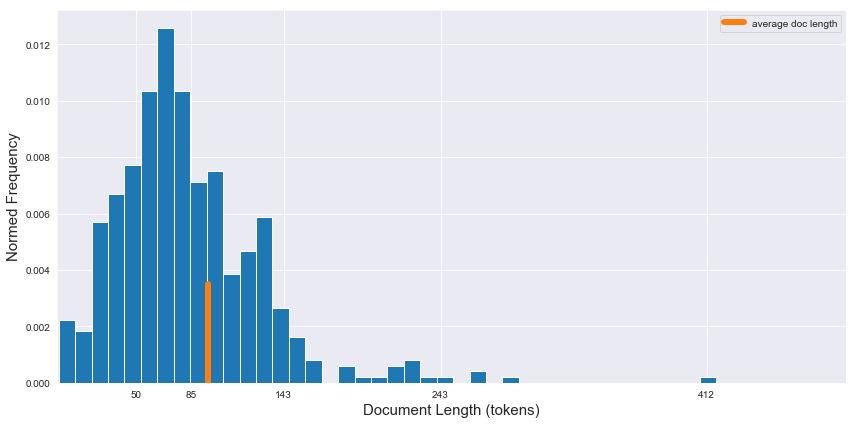

In [94]:
# plot a histogram of document length
num_bins = 300
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, density=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(2000),num=8, base=10.0))
plt.xlim(0,500)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,500)], np.linspace(0.0,0.0035,500), '-',
        label='average doc length', linewidth=6)
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [95]:
# only keep articles with more than 10 tokens, otherwise they are too short
df = df[df['tokenized_abstracts'].map(len) >= 10]

# make sure all tokenized items are lists
df = df[df['tokenized_abstracts'].map(type) == list]

df.reset_index(drop=True,inplace=True)

print(f"After cleaning and excluding short aticles, the dataframe now has {len(df)} articles")

After cleaning and excluding short aticles, the dataframe now has 462 articles


In [125]:
# For the sake of the presentation, I would like some way to represent that the topic model performs
# well on unseen articles. To do this, I'll split the dataset into a training and test set,
# and show how the model does with an article in both sets.

# I want to keep the training and test sets in Panda's dataframes, and so I use Andy Hayden's implementation 
# https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas)
# from Stack Overflow.

# create a mask of binary values
msk = np.random.rand(len(df)) < 0.80

train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [126]:
# A quick sanity check to see how the split worked out.
test_df.head(100)

,article_ID,Journal_Title,Article_Title,Article_Abstract,Authors,Year_of_Publication,tokenized_abstracts
0,4,Teacher Education Quarterly,Mathematics Teacher Educators Focusing on Equi...,The article presents the result of the qualita...,"['Vomvoridi-Ivanovic, Eugenia', 'McLeman, Laura']",2015,"[articl, present, result, qualit, studi, educ,..."
1,7,Cultural Studies of Science Education,Expanding and enacting transformative meanings...,"In this paper, we provide a conceptual critiqu...","['Rodriguez, Alberto J.', 'Morrison, Deb']",2019,"[paper, provid, conceptu, critiqu, variou, con..."
2,8,"Pedagogy, Culture & Society",Critical relationships between teachers and le...,This article draws on critical theories and pe...,"Wright, Pete",2017,"[articl, draw, critic, theori, perspect, expla..."
3,10,International Journal of Science Education,A STEM extended learning project to raise awar...,Governments worldwide are advocating for STEM ...,"['Mildenhall, P.', 'Cowie, B.', 'Sherriff, B.']",2019,"[govern, worldwid, advoc, stem, curricula, ess..."
4,11,"Journal of Language, Identity & Education",Mathematical Classroom Discussion as an Equita...,This mixed-method study examines the relations...,"['Banes, Leslie C.', 'Ambrose, Rebecca C.', 'B...",2018,"[mixedmethod, studi, examin, relationship, cla..."
...,...,...,...,...,...,...,...
85,440,American Journal of Education,Differentiation and opportunity in restructure...,"In this article, the authors examine the respo...","['Gamoran, Adam', 'Weinstein, Matthew G.']",1998,"[articl, author, examin, respons, highli, rest..."
86,454,Instrumentalist,Educational Trends Change Every 10 Years.,Just as mathematics and language courses are r...,"Groeling, Charles",2005,"[languag, cours, regard, prerequisit, advanc, ..."
87,466,Journal of Education Policy,"Children, power and schooling: how childhood i...","Children, power and schooling: how childhood i...","Brooker, Liz",2005,"[children, power, school, childhood, structur,..."
88,470,American School Board Journal,Bridging the opinion gap.,Part of a special report on the state of educa...,"Hardy, Lawrence",2008,"[part, special, report, state, recent, studi, ..."


In [127]:
# A quick sanity check to see how large each of the dataframes are:

print(len(df),len(train_df),len(test_df))

462 372 90


In [128]:
def train_lda(data):
    """
    This function trains the LDA model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do a few passes of the data since this is a small dataset, so we want the distributions to stabilize
    
    Gensim's ldamodel documentation is very helpful here. https://radimrehurek.com/gensim/models/ldamodel.html
    """
    
    # I tried out a number of num_topics hyper-parameter values. For the sake of this presentation, let's
    # use 9.
    
    num_topics = 9
    chunksize = 100
    dictionary = corpora.Dictionary(data['tokenized_abstracts'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized_abstracts']]
    
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-1, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    return dictionary,corpus,lda

In [129]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 
dictionary,corpus,lda = train_lda(train_df)

In [130]:
# show_topics method shows the the top num_words contributing to num_topics number of random topics
lda.show_topics(num_topics=10, num_words=20)

[(0,
  '0.040*"student" + 0.021*"use" + 0.014*"teacher" + 0.013*"practic" + 0.013*"activ" + 0.012*"studi" + 0.012*"argument" + 0.011*"classroom" + 0.010*"assess" + 0.010*"learn" + 0.009*"mathemat" + 0.009*"instruct" + 0.009*"grade" + 0.008*"work" + 0.008*"teach" + 0.008*"model" + 0.008*"method" + 0.008*"scienc" + 0.008*"task" + 0.008*"present"'),
 (1,
  '0.034*"design" + 0.034*"technolog" + 0.028*"game" + 0.020*"learn" + 0.019*"teach" + 0.018*"math" + 0.018*"paper" + 0.018*"comput" + 0.017*"topic" + 0.016*"histor" + 0.016*"research" + 0.015*"scienc" + 0.014*"univers" + 0.014*"us" + 0.010*"draw" + 0.010*"natur" + 0.010*"digit" + 0.009*"institut" + 0.009*"practic" + 0.008*"process"'),
 (2,
  '0.038*"student" + 0.027*"school" + 0.018*"effect" + 0.015*"cours" + 0.014*"whether" + 0.013*"public" + 0.012*"may" + 0.011*"progress" + 0.011*"secondari" + 0.011*"teacher" + 0.010*"calcul" + 0.010*"educ" + 0.010*"five" + 0.009*"use" + 0.009*"state" + 0.009*"need" + 0.009*"train" + 0.009*"research" +

In [131]:
lda.show_topic(topicid=5, topn=10)

[('teacher', 0.029727036),
 ('learn', 0.021832606),
 ('develop', 0.016977374),
 ('teach', 0.016281899),
 ('profession', 0.013380745),
 ('student', 0.013061991),
 ('practic', 0.011171207),
 ('research', 0.011054691),
 ('equiti', 0.011044481),
 ('paper', 0.009712588)]

In [139]:
cool_article_index = 26
print(train_df.iloc[cool_article_index, 4])
print(train_df.iloc[cool_article_index, 2])

['Gholson, Maisie L.', 'Robinson, Darrius D.']
Restoring Mathematics Identities of Black Learners: A Curricular Approach.


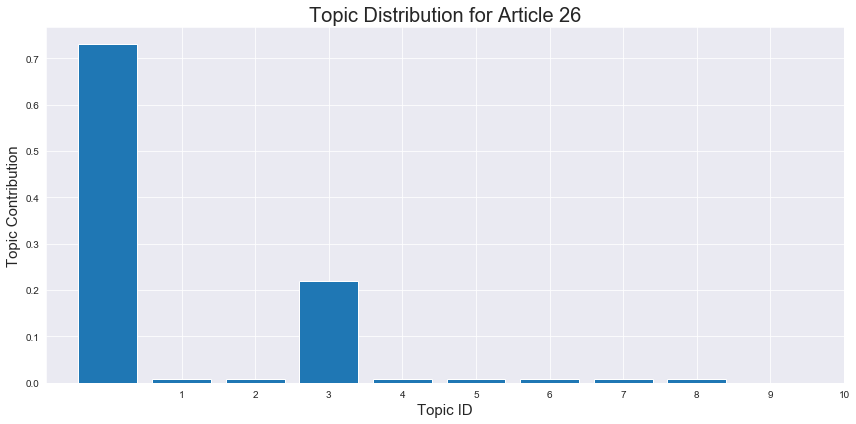

In [141]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(cool_article_index), fontsize=20)
ax.set_xticks(np.linspace(1,10,10))
fig.tight_layout()
plt.show()

In [142]:
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

0 [('student', 0.0398896), ('use', 0.021482676), ('teacher', 0.014014022), ('practic', 0.013115137), ('activ', 0.013094595), ('studi', 0.012201072), ('argument', 0.01156762), ('classroom', 0.01098312), ('assess', 0.010253), ('learn', 0.009985131)] 

3 [('social', 0.026852507), ('classroom', 0.020049958), ('critic', 0.016584437), ('student', 0.015058692), ('justic', 0.014877043), ('research', 0.014284513), ('issu', 0.013262216), ('practic', 0.012655661), ('cultur', 0.012027996), ('learn', 0.011382988)] 

8 [('student', 0.027942406), ('teacher', 0.015792683), ('practic', 0.015762564), ('learn', 0.013338905), ('discuss', 0.012143958), ('articl', 0.011799607), ('use', 0.01125518), ('special', 0.010882776), ('children', 0.010859755), ('issu', 0.010826638)] 

6 [('classroom', 0.045739256), ('teacher', 0.030952249), ('inquiri', 0.027582766), ('practic', 0.022795806), ('student', 0.021509994), ('writer', 0.020793218), ('learn', 0.015391924), ('equiti', 0.014978637), ('knowledg', 0.012623725), 

In [147]:
# select and article at random from test_df
random_article_index = np.random.randint(len(test_df))
print(random_article_index)

69


In [148]:
new_bow = dictionary.doc2bow(test_df.iloc[random_article_index,6])

In [149]:
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])

In [150]:
print(test_df.iloc[random_article_index,3])

Social work programs are increasingly relying on study abroad to prepare students for global practice. A growing body of literature reports on the positive features of international education, yet little attention has been focused on preparing social work programs and the faculty who lead them to handle the emergencies that can arise during study abroad. This paper uses a case study of an actual emergency in a study abroad program to examine how the event was handled and to assess its short- and long-term consequences. Elements of the case are analyzed in an effort to identify general issues for study abroad programs to consider.


In [151]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])

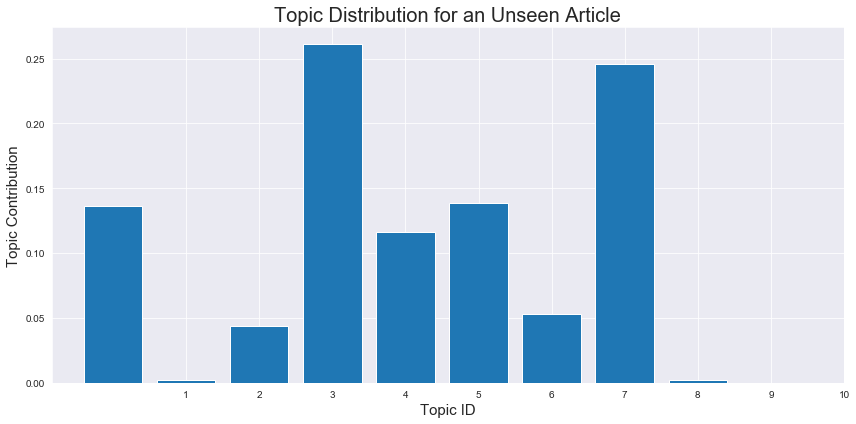

In [152]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
ax.set_xticks(np.linspace(1,10,10))
fig.tight_layout()
plt.show()

In [153]:
# print the top 8 contributing topics and their words
for i in new_doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

3 [('social', 0.026852507), ('classroom', 0.020049958), ('critic', 0.016584437), ('student', 0.015058692), ('justic', 0.014877043), ('research', 0.014284513), ('issu', 0.013262216), ('practic', 0.012655661), ('cultur', 0.012027996), ('learn', 0.011382988)] 

7 [('student', 0.021367516), ('teacher', 0.01461955), ('polici', 0.014429573), ('standard', 0.011598295), ('studi', 0.011437039), ('differ', 0.010324607), ('natur', 0.010002241), ('practic', 0.009968425), ('countri', 0.009957071), ('achiev', 0.009803803)] 

5 [('teacher', 0.029727036), ('learn', 0.021832606), ('develop', 0.016977374), ('teach', 0.016281899), ('profession', 0.013380745), ('student', 0.013061991), ('practic', 0.011171207), ('research', 0.011054691), ('equiti', 0.011044481), ('paper', 0.009712588)] 

0 [('student', 0.0398896), ('use', 0.021482676), ('teacher', 0.014014022), ('practic', 0.013115137), ('activ', 0.013094595), ('studi', 0.012201072), ('argument', 0.01156762), ('classroom', 0.01098312), ('assess', 0.010253

In [154]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
vis

C:\Users\Mike\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.038598 -0.019822       1        1  18.784523
8      0.005333 -0.007528       2        1  16.271008
7      0.078514  0.006567       3        1  16.131416
5     -0.003024 -0.037748       4        1  12.228482
3     -0.090107 -0.106890       5        1  11.158866
6      0.074383 -0.123168       6        1   7.052079
2      0.204048  0.148122       7        1   7.023536
4     -0.109447 -0.029986       8        1   6.501136
1     -0.198297  0.170453       9        1   4.848948, topic_info=     Category        Freq       Term       Total  loglift  logprob
41    Default  363.000000     scienc  363.000000  30.0000  30.0000
5     Default  317.000000  classroom  317.000000  29.0000  29.0000
789   Default  135.000000  technolog  135.000000  28.0000  28.0000
546   Default  127.000000     design  127.000000  27.0000  27.0000
1292  Default   73.000000    inquiri   73.000000  26.0000  26.0000
...       ...         ...        ...         ...      ...      ...
777    Topic9   11.828849     experi  120.533180   0.7050  -4.9104
211    Topic9   12.261147       educ  181.848633   0.3297  -4.8745
52     Topic9   12.381148        use  360.369324  -0.3445  -4.8647
8      Topic9   10.631798       data  128.458054   0.5347  -5.0171
169    Topic9   11.266308    student  810.945435  -1.2500  -4.9591

[687 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1141      2  0.016834     abil
1141      3  0.084168     abil
1141      4  0.521840     abil
1141      5  0.185169     abil
1141      7  0.084168     abil
...     ...       ...      ...
872       5  0.042416    youth
872       6  0.042416    youth
872       8  0.508995    youth
872       9  0.042416    youth
1043      6  1.104303  zealand

[1582 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 9, 8, 6, 4, 7, 3, 5, 2])

In [155]:
pyLDAvis.save_html(vis, 'visuals/vis7.html')

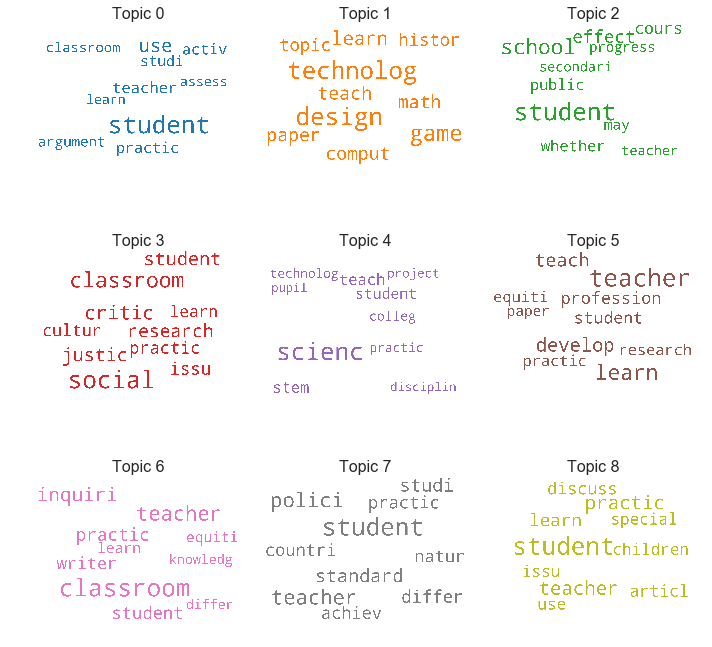

<Figure size 432x288 with 0 Axes>

In [171]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

plt.savefig('topics.png', transparent=True)

In [172]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=all_words):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=all_words)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Article_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Most_Common_Word']
df_dominant_topic.head(10)

,Article_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Most_Common_Word
0,0,0.0,0.8886,"student, use, teacher, practic, activ, studi, ...",studi
1,1,7.0,0.9882,"student, teacher, polici, standard, studi, dif...",assess
2,2,3.0,0.9893,"social, classroom, critic, student, justic, re...",reliabl
3,3,3.0,0.5754,"social, classroom, critic, student, justic, re...",two
4,4,6.0,0.6992,"classroom, teacher, inquiri, practic, student,...",observ
5,5,7.0,0.8956,"student, teacher, polici, standard, studi, dif...",rubric
6,6,7.0,0.8502,"student, teacher, polici, standard, studi, dif...",one
7,7,7.0,0.9830,"student, teacher, polici, standard, studi, dif...",math
8,8,1.0,0.7214,"design, technolog, game, learn, teach, math, p...",scienc
9,9,6.0,0.4599,"classroom, teacher, inquiri, practic, student,...",document


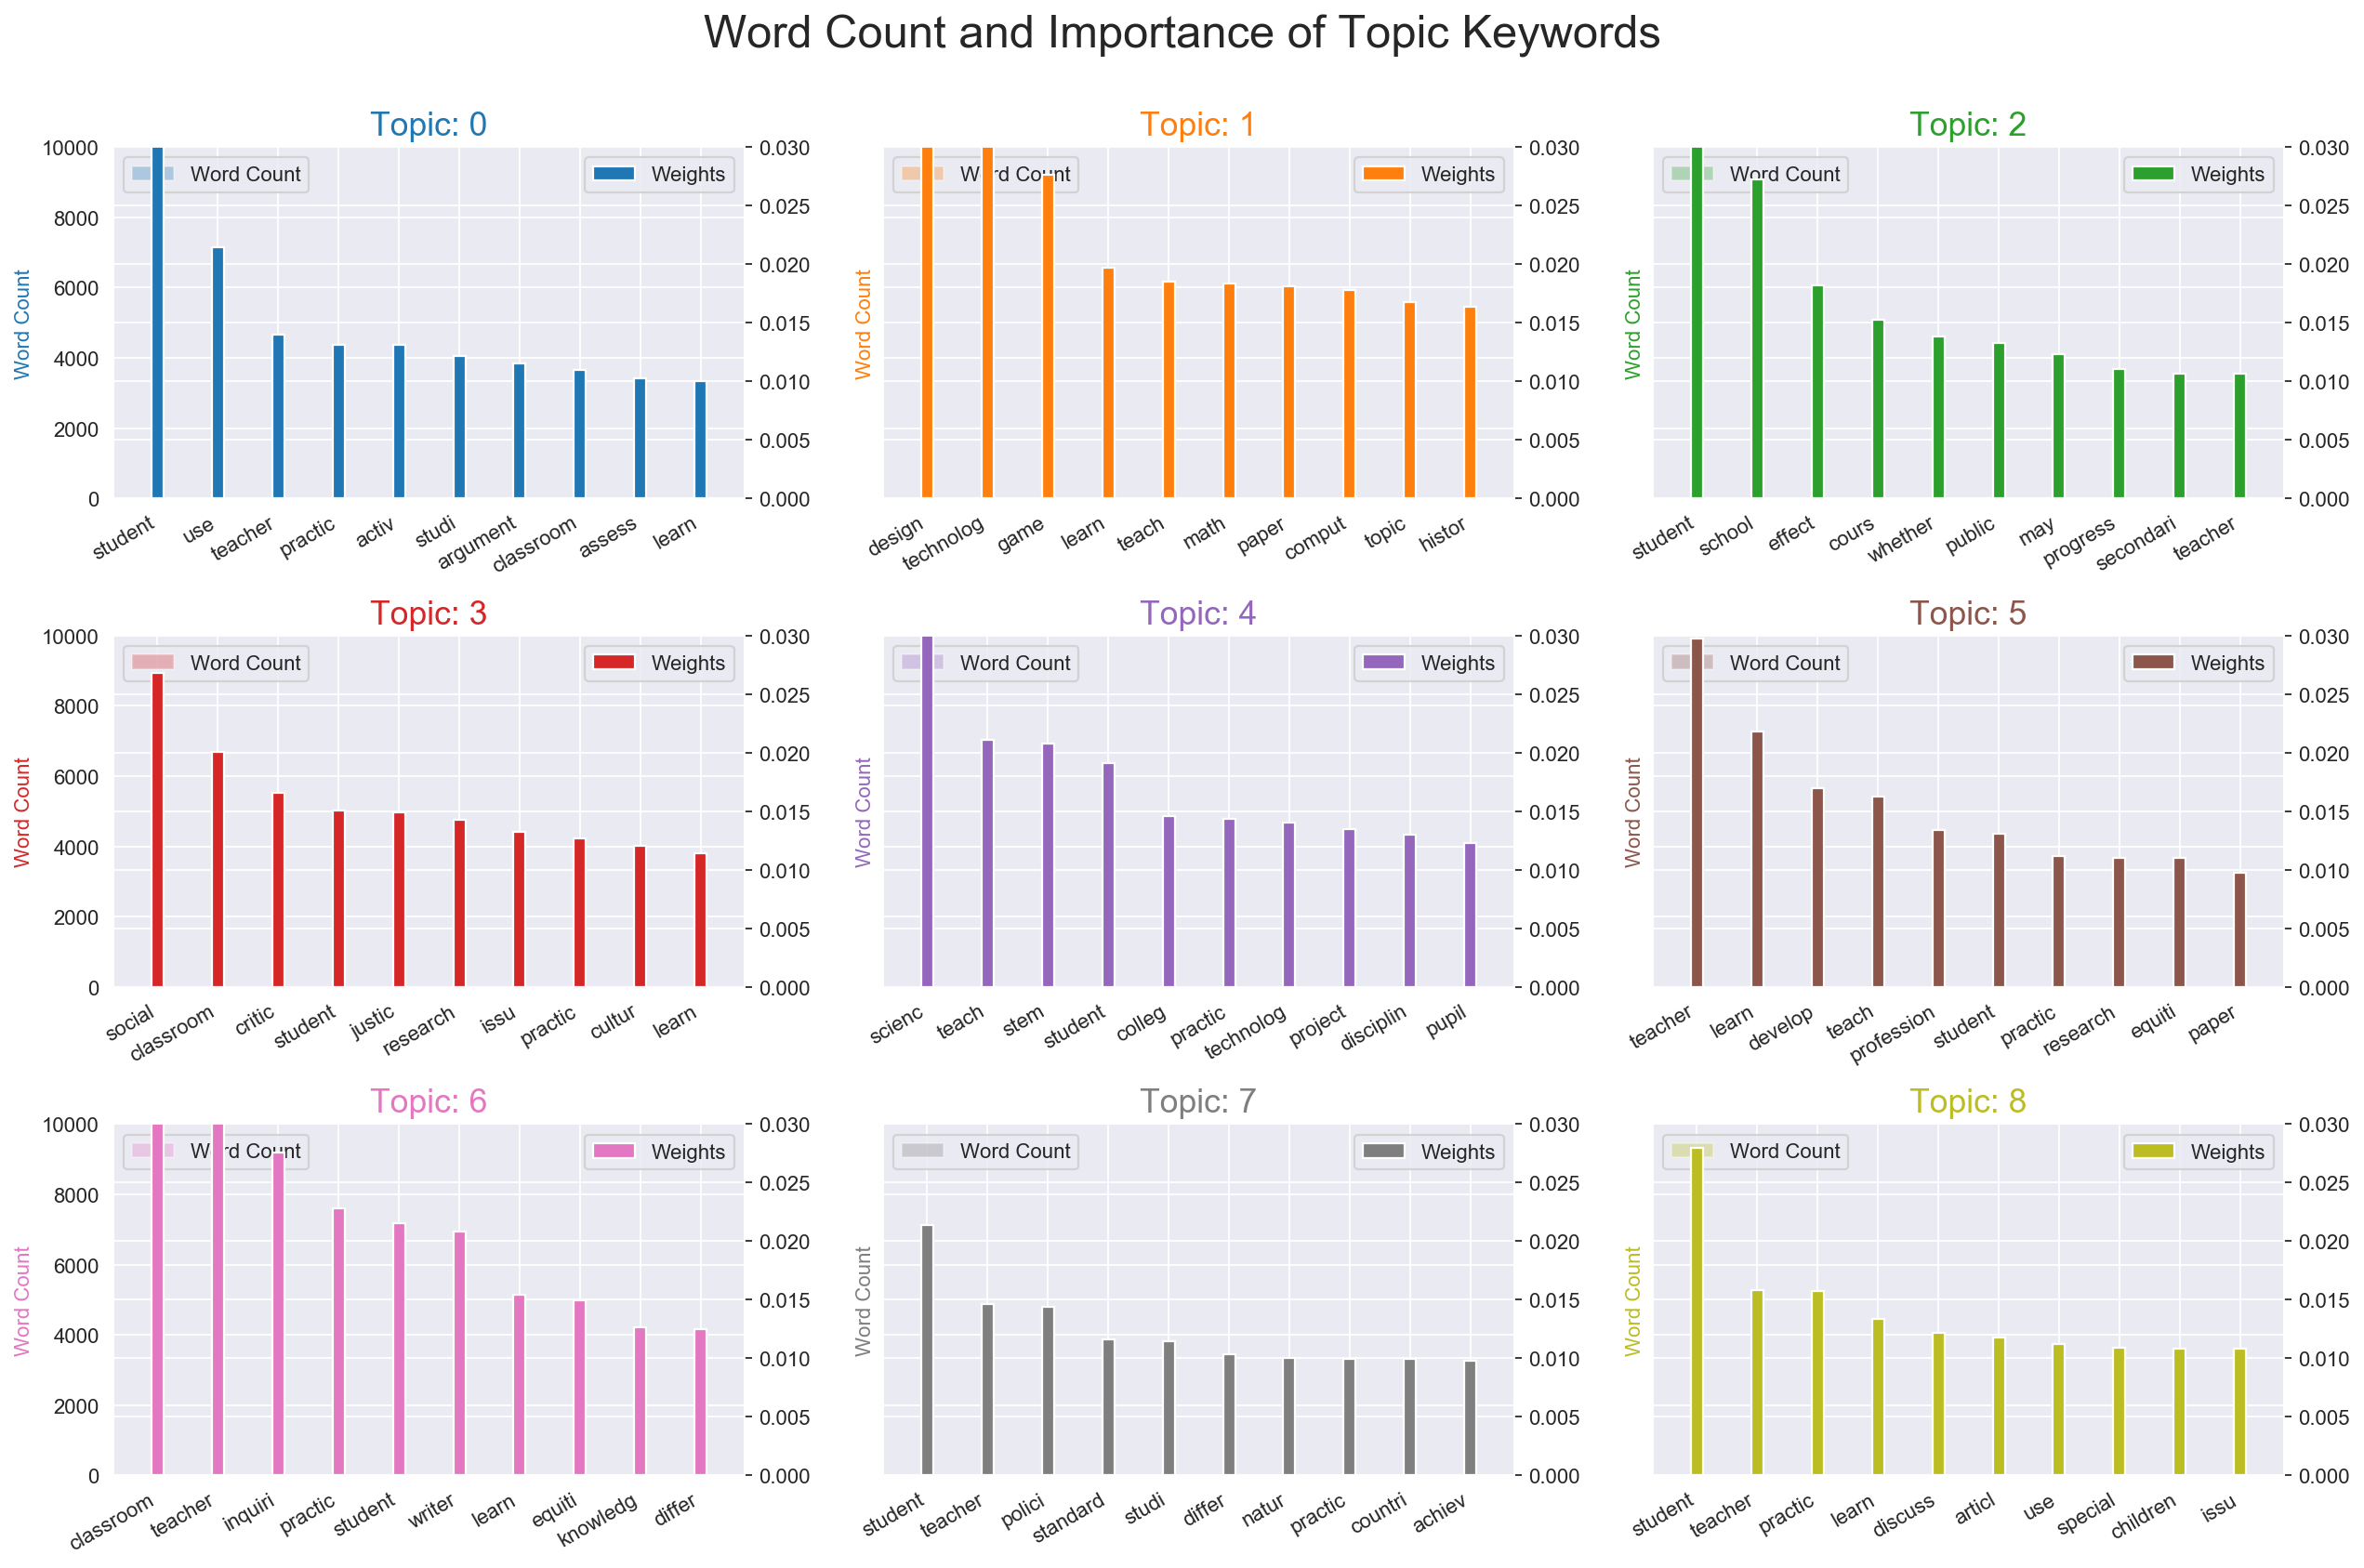

In [174]:
from collections import Counter
topics = lda.show_topics(formatted=False)
data_flat = [w for w_list in all_words for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(3, 3, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 10000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()